In [1]:
import sys
import gzip
import torch
import random
import itertools
import torch.nn as nn
import tikzplotlib
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

sys.path.append('../')

from src.deepfashion.dataset import DeepFashionDataset, INVERSE_IMG_TRANSFORM
from src.fashionnet.model import FashionNet, PredictionHead
from src.attacks.recommender import fgsm_sim_attack, pgd_sim_attack
from src.attacks.classifier import fgsm_classifier_attack, pgd_classifier_attack
from src.helpers import cos_dist

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ' + str(device))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Device: cuda:0


In [24]:
model_name = 'normal-24-epochs'
fashion_dataset = DeepFashionDataset(root_dir='../data/DeepFashion/')
fashion_net = FashionNet(device, fashion_dataset.num_categories, fashion_dataset.num_textures)
fashion_net.load('../results/models/' + model_name + '.pt')
fashion_net.model.eval()

old_classifier = fashion_net.model.classifier
fashion_net.model.classifier = nn.Sequential()

In [25]:
target_id = fashion_dataset.category_labels.index.get_loc('img_resized/Striped_Textured_Sweater/img_00000024.jpg')
attack_id = fashion_dataset.category_labels.index.get_loc('img_resized/Linen-Blend_Drawstring_Shorts/img_00000026.jpg')

## Perform FGSM attack on cosine similarity

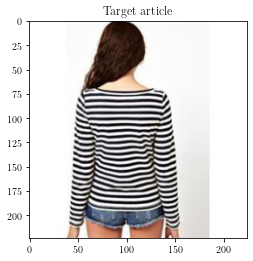

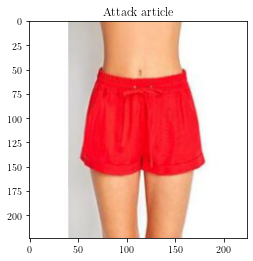

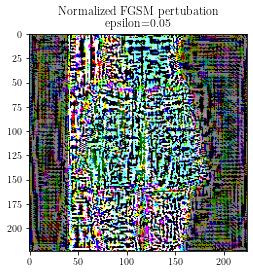

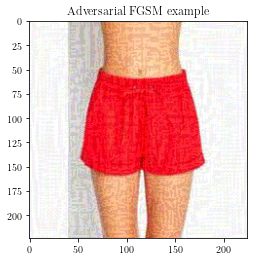

Cosine distance before attack: 0.6247546672821045
Cosine distance after attack: 0.5584423542022705


In [26]:
target_image = fashion_dataset[target_id]['image'].to(device)
plt.title('Target article')
plt.imshow(INVERSE_IMG_TRANSFORM(target_image.cpu()))
plt.show()

attack_image = fashion_dataset[attack_id]['image'].to(device)
plt.title('Attack article')
plt.imshow(INVERSE_IMG_TRANSFORM(attack_image.cpu()))
plt.show()

INVERSE_IMG_TRANSFORM(target_image.cpu()).save('../doc/thesis/images/adv/target.jpg')
INVERSE_IMG_TRANSFORM(attack_image.cpu()).save('../doc/thesis/images/adv/original.jpg')

epsilon = 0.05
target_vec = fashion_net.model(target_image.unsqueeze(0)).detach()
adversarial_image = fgsm_sim_attack(fashion_net, target_vec, attack_image.unsqueeze(0), epsilon)[0]

final_pertubation = adversarial_image - attack_image
min_pertubation = torch.min(final_pertubation)
max_pertubation = torch.max(final_pertubation)
visualized_pertubation = (final_pertubation - min_pertubation) / (max_pertubation - min_pertubation)

plt.title('Normalized FGSM pertubation \n epsilon=' + str(epsilon))
plt.imshow(INVERSE_IMG_TRANSFORM(visualized_pertubation.cpu()))
plt.show()
    
plt.title('Adversarial FGSM example')
plt.imshow(INVERSE_IMG_TRANSFORM(adversarial_image.cpu()))
plt.show()

prediction = fashion_net.model(torch.stack([attack_image, adversarial_image]))
attack_vec = prediction[0].unsqueeze(0)
adversarial_vec = prediction[1].unsqueeze(0)

print('Cosine distance before attack: ' + str(cos_dist(target_vec, attack_vec).item()))
print('Cosine distance after attack: ' + str(cos_dist(target_vec, adversarial_vec).item()))

INVERSE_IMG_TRANSFORM(visualized_pertubation.cpu()).save('../doc/thesis/images/adv/fgsm/pertubation.jpg')
INVERSE_IMG_TRANSFORM(adversarial_image.cpu()).save('../doc/thesis/images/adv/fgsm/attack.jpg')

## Perform PGD attack on cosine similarity

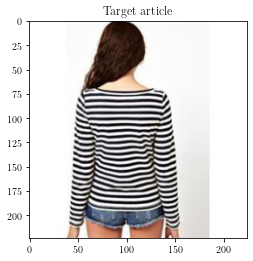

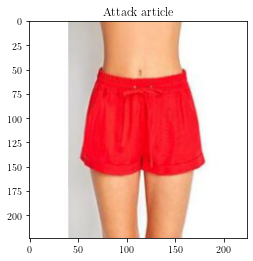

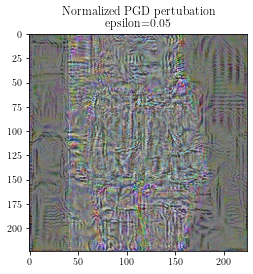

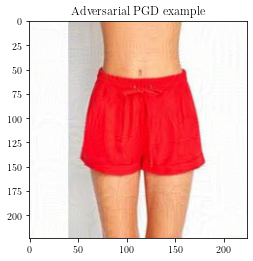

Cosine distance before attack: 0.6247546672821045
Cosine distance after attack: 0.0397491455078125


In [27]:
target_image = fashion_dataset[target_id]['image'].to(device)
plt.title('Target article')
plt.imshow(INVERSE_IMG_TRANSFORM(target_image.cpu()))
plt.show()

attack_image = fashion_dataset[attack_id]['image'].to(device)
plt.title('Attack article')
plt.imshow(INVERSE_IMG_TRANSFORM(attack_image.cpu()))
plt.show()

epsilon = 0.05
target_vec = fashion_net.model(target_image.unsqueeze(0)).detach()
adversarial_image = pgd_sim_attack(fashion_net, target_vec, attack_image.unsqueeze(0), epsilon, k=32)[0]

final_pertubation = adversarial_image - attack_image
min_pertubation = torch.min(final_pertubation)
max_pertubation = torch.max(final_pertubation)
visualized_pertubation = (final_pertubation - min_pertubation) / (max_pertubation - min_pertubation)

plt.title('Normalized PGD pertubation \n epsilon=' + str(epsilon))
plt.imshow(INVERSE_IMG_TRANSFORM(visualized_pertubation.cpu()))
plt.show()
    
plt.title('Adversarial PGD example')
plt.imshow(INVERSE_IMG_TRANSFORM(adversarial_image.cpu()))
plt.show()

prediction = fashion_net.model(torch.stack([attack_image, adversarial_image]))
attack_vec = prediction[0].unsqueeze(0)
adversarial_vec = prediction[1].unsqueeze(0)

print('Cosine distance before attack: ' + str(cos_dist(target_vec, attack_vec).item()))
print('Cosine distance after attack: ' + str(cos_dist(target_vec, adversarial_vec).item()))

INVERSE_IMG_TRANSFORM(visualized_pertubation.cpu()).save('../doc/thesis/images/adv/pgd/pertubation.jpg')
INVERSE_IMG_TRANSFORM(adversarial_image.cpu()).save('../doc/thesis/images/adv/pgd/attack.jpg')

## Evaluate classifier predictions after attack

/home/pnormann/.local/share/virtualenvs/master-thesis-O-UFlab8/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[tensor(0.0031), tensor(0.0054), tensor(0.0059), tensor(0.0163), tensor(0.0169), tensor(0.0173), tensor(0.0371), tensor(0.1207), tensor(0.2472), tensor(0.5157)]
['Dress', 'Tank', 'Shorts', 'Henley', 'Cardigan', 'Hoodie', 'Blouse', 'Top', 'Sweater', 'Tee']
[tensor(0.0112), tensor(0.0113), tensor(0.0180), tensor(0.0208), tensor(0.0211), tensor(0.0219), tensor(0.0250), tensor(0.0453), tensor(0.1997), tensor(0.4596)]
['nautical stripe', 'print', 'stripes', 'nautical', 'marled', 'nautical striped', 'breton stripe', 'breton', 'stripe', 'striped']


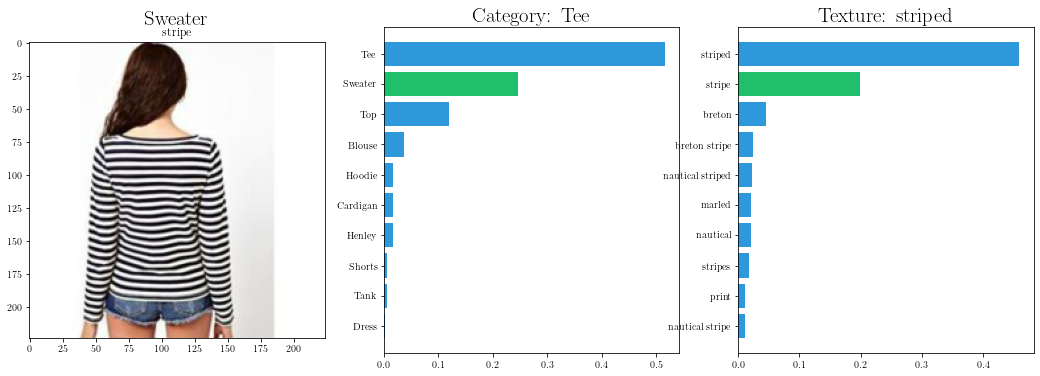

[tensor(1.8125e-06), tensor(2.8439e-06), tensor(1.1450e-05), tensor(2.1354e-05), tensor(2.3611e-05), tensor(8.1404e-05), tensor(0.0002), tensor(0.0003), tensor(0.0222), tensor(0.9772)]
['Blouse', 'Joggers', 'Top', 'Leggings', 'Culottes', 'Sweatshorts', 'Cutoffs', 'Skirt', 'Trunks', 'Shorts']
[tensor(0.0214), tensor(0.0237), tensor(0.0342), tensor(0.0507), tensor(0.0668), tensor(0.0741), tensor(0.0823), tensor(0.0834), tensor(0.0878), tensor(0.2200)]
['floral print', 'pom-pom', 'tribal', 'stripe', 'printed', 'polka dot', 'dot', 'floral', 'striped', 'print']


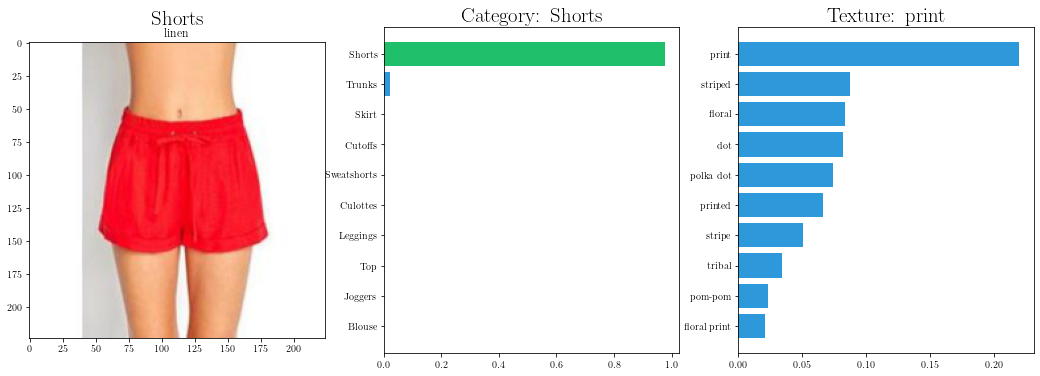

[tensor(0.0006), tensor(0.0009), tensor(0.0019), tensor(0.0048), tensor(0.0065), tensor(0.0126), tensor(0.0204), tensor(0.0847), tensor(0.2934), tensor(0.5717)]
['Blazer', 'Shorts', 'Tank', 'Henley', 'Hoodie', 'Cardigan', 'Blouse', 'Top', 'Sweater', 'Tee']
[tensor(0.0070), tensor(0.0086), tensor(0.0095), tensor(0.0112), tensor(0.0113), tensor(0.0135), tensor(0.0156), tensor(0.0212), tensor(0.2576), tensor(0.5574)]
['graphic', 'linen', 'print', 'breton', 'nautical', 'colorblock', 'stripes', 'marled', 'stripe', 'striped']


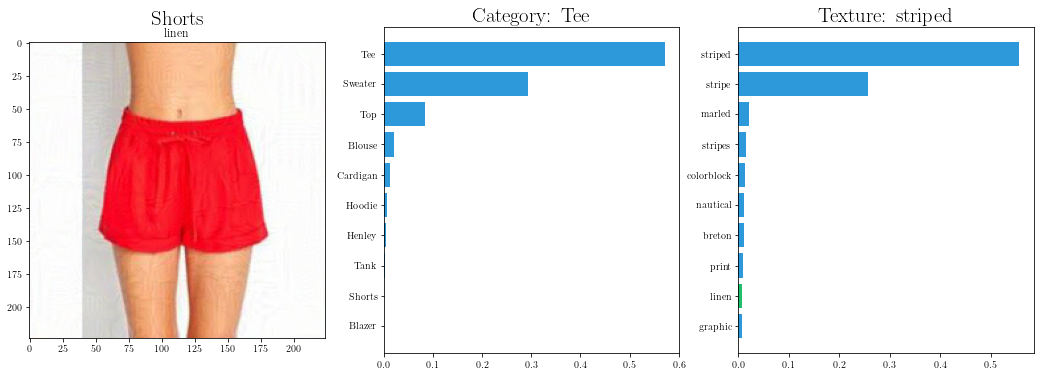

[tensor(1.4699e-19), tensor(1.5611e-19), tensor(1.1165e-18), tensor(3.5905e-18), tensor(4.4371e-18), tensor(3.8279e-17), tensor(5.0281e-17), tensor(6.3417e-17), tensor(1.1065e-13), tensor(1.)]
['Sweatshorts', 'Top', 'Sweater', 'Leggings', 'Jersey', 'Tee', 'Shorts', 'Tank', 'Henley', 'Trunks']
[tensor(6.2051e-07), tensor(1.0934e-06), tensor(7.2380e-06), tensor(1.3386e-05), tensor(5.0931e-05), tensor(7.9651e-05), tensor(0.0006), tensor(0.0791), tensor(0.2423), tensor(0.6779)]
['tribal', 'print', 'geo print', 'nautical', 'colorblocked', 'geo', 'stripes', 'stripe', 'colorblock', 'striped']


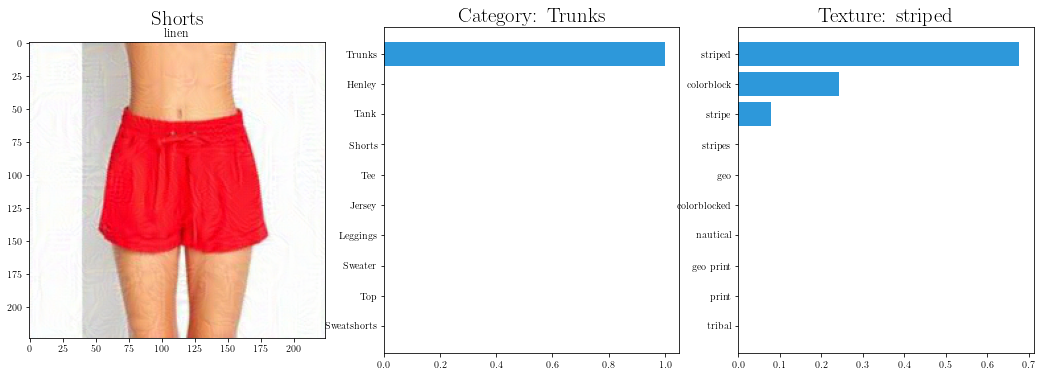

In [28]:
fashion_net.model.classifier = old_classifier

category_criterion = nn.CrossEntropyLoss()
texture_criterion = nn.BCEWithLogitsLoss()

adversarial_classifier_image = pgd_classifier_attack(fashion_net, attack_image.unsqueeze(0),
                                                     torch.tensor(fashion_dataset[attack_id]['category']).unsqueeze(0).to(device), 
                                                     torch.tensor(fashion_dataset[attack_id]['textures']).unsqueeze(0).to(device),
                                                     category_criterion, texture_criterion, epsilon=0.05, k=100)[0]

batch = {'image': torch.stack([target_image, attack_image, adversarial_image, adversarial_classifier_image]).cpu(),
         'name': ['target_image','attack_image', 'adversarial_sim_image', 'adversarial_classifier_image'], 
         'category': [fashion_dataset[target_id]['category'], fashion_dataset[attack_id]['category'], fashion_dataset[attack_id]['category'], fashion_dataset[attack_id]['category']],
         'textures': [fashion_dataset[target_id]['textures'], fashion_dataset[attack_id]['textures'], fashion_dataset[attack_id]['textures'], fashion_dataset[attack_id]['textures']]}

fashion_dataset.visualize_predictions(fashion_net, batch)

fashion_net.model.classifier = nn.Sequential()